In [1]:
import numpy as np
import numpy.linalg as npl
import math
import matplotlib.pyplot as plt
import sys
from scipy.integrate import odeint

# 9.3 Epidemic Dynamics

**Simple SIR Model - Activity ONE**

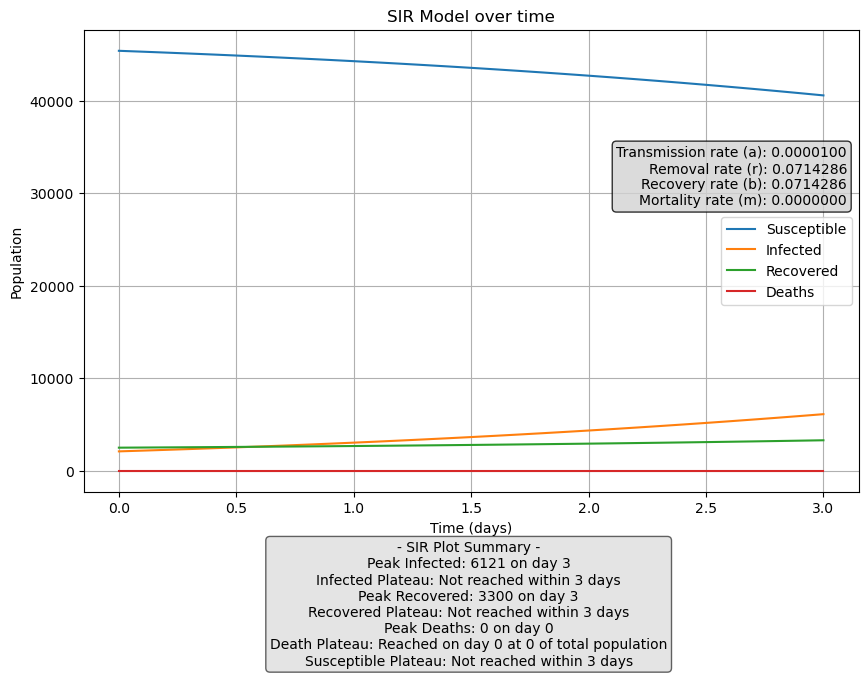

160


In [2]:

#Use Pseudocode from Calculus in Context, Chapter 2 page 69 to plot the 3 functions S, I and R. Use a (.00001)and b (14) as varibles instead of numbers
#Use a fixed plot window with y as the total height and fix the number of days you want to explore.
#Once it is working, add a new rate equation for Deaths by splitting up the "Recovered" 2 equations - for example 10 percent pass to death and 90 percent pass to recovered.
#Please comment your code.

# threshold controls sensitivity: lower = flatter
# min_length_fraction ensures validity
def findPlateau(t_values, y_values, threshold=1.0, min_length_fraction=0.1):
    # ensures min_length scales with larger data sets, but doesn't get too small for small data sets
    min_length = max(5, int(len(t_values) * min_length_fraction))
    count = 0
    start_idx = None
    # calculate y_values deltas
    deltas = [abs(y2 - y1) for y1, y2 in zip(y_values[:-1], y_values[1:])]

    # determine count of deltas that are within plateau
    for idx, delta in enumerate(deltas):
        if delta < threshold:
            count += 1
            if count == min_length:
                # if deltas within threshold meet min_length determine start index of plateau
                start_idx = idx - min_length + 1
                break
        else:
            count = 0

    if start_idx is not None:
        return (f"Reached on day {t_values[start_idx]:.0f} at {y_values[start_idx]:.0f} of total population")
    else:
        return (f"Not reached within {max(t_values):.0f} days")

def plotSIR(a, B, b, m, t_values, S_values, I_values, R_values, D_values, total_pop, t_initial, t_final):
    plt.figure(figsize=(10, 6))
    lines = [
        (S_values, "Susceptible"),
        (I_values, "Infected"),
        (R_values, "Recovered"),
        (D_values, "Deaths")
    ]
    for y_values, label in lines:
        #plt.plot(t_values, y_values, label, marker='.', markersize=4) # if you want to see steps on line
        plt.plot(t_values, y_values, label = label)
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.title("SIR Model over time")
    plt.xlim(t_initial, t_final)
    plt.ylim(0, total_pop)
    plt.legend()
    plt.grid(True)
    plt.autoscale()
    param_text = (
        f"Transmission rate (a): {a:.7f}\n"
        f"Removal rate (r): {1/B:.7f}\n"
        f"Recovery rate (b): {b:.7f}\n"
        f"Mortality rate (m): {m:.7f}"
    )
    plt.annotate(
        param_text,
        xy=(0.985, 0.75),             # position in axes fraction coords
        xycoords='axes fraction',
        fontsize=10,
        ha='right',
        va='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    )
    peak_text = (
        f"- SIR Plot Summary -\n"
        f"Peak Infected: {max(I_values):.0f} on day {t_values[I_values.index(max(I_values))]:.0f}\n"
        f"Infected Plateau: {findPlateau(t_values, I_values)}\n"
        f"Peak Recovered: {max(R_values):.0f} on day {t_values[R_values.index(max(R_values))]:.0f}\n"
        f"Recovered Plateau: {findPlateau(t_values, R_values)}\n"
        f"Peak Deaths: {max(D_values):.0f} on day {t_values[D_values.index(max(D_values))]:.0f}\n"
        f"Death Plateau: {findPlateau(t_values, D_values, .5)}\n"
        f"Susceptible Plateau: {findPlateau(t_values, S_values)}"
    )
    
    plt.figtext(
        0.51, -0.175, peak_text,
        wrap=True, ha='center', fontsize=10,
        bbox=dict(boxstyle="round", facecolor="lightgray", edgecolor="black", alpha=0.6)
    )
    plt.show()


# dictionary of SIR_inputs outline
    # t_initial :           # start day of model
    # t_final :             # end day of model
    # step_scale :          # 0 to X number to deterimine how many data points are taken between t_initial and t_final. 1 means same number of steps as days, so 1 to 1
    # a :                   # transmission coefficient, rate of people getting sick per contact
    # B :                   # coefficient for removal of Infected / X days
    # total_pop :           # total Population
    # mortality_risk :      # percentage (in decimal form) of those that are infected that die
    # I_init :              # infected on start day
    # R_init :              # recovered on start day
    # D_init :              # deaths on start day                  
    # output_path :         # path for data to write to
def SIR(SIR_inputs):
    # deserialize SIR_inputs into variables
    t_initial = SIR_inputs["t_initial"]
    t_final = SIR_inputs["t_final"]
    step_scale = SIR_inputs["step_scale"]
    a = SIR_inputs["a"]
    B = SIR_inputs["B"]
    total_pop = SIR_inputs["total_pop"]
    mortality_risk = SIR_inputs["mortality_risk"]
    I_init = SIR_inputs["I_init"]
    R_init = SIR_inputs["R_init"]
    D_init = SIR_inputs["D_init"]
    output_path = SIR_inputs["output_path"]

    # set values for use in loop
    t = t_initial                   # start time
    I = I_init                      # total infected
    R = R_init                      # total recovered
    D = D_init                      # total dead
    S = total_pop - I - R - D       # total susceptible
    
    r = 1/B                         # removal (recovery + deaths) rate
    b = r * (1 - mortality_risk)    # recovery rate
    m = r * mortality_risk          # mortality rate
    
    steps = (t_final - t_initial) * step_scale # how many data points within set days
    deltat = (t_final - t_initial)/steps

    sys.stdout = open(output_path, "w") # write output to file instead of console
    print("{:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".
        format("Increment #", "Susceptible", "Infected", "Recovered", "Deaths", "Sprime", "Iprime", "Rprime"))        
    print("{:<15} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}".
        format(t, S, I, R, D))

    # store values for graph, initialize lists with starting values
    t_values = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]
    D_values = [D]
    for  k in range(steps):
        Sprime = -a * S * I
        Iprime = (a * S * I) - (I * r)
        Rprime = I * b
        Dprime = I * m
        deltaS = Sprime * deltat
        deltaI = Iprime * deltat
        deltaR = Rprime * deltat
        deltaD = Dprime * deltat
        # update values with delta change
        t = t + deltat
        S = S + deltaS
        I = I + deltaI
        R = R + deltaR
        D = D + deltaD
        # save values in lists
        t_values.append(t)
        S_values.append(S)
        I_values.append(I)
        R_values.append(R)
        D_values.append(D)
        print("{:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}, {:<15.3f}".
            format(t, S, I, R, D, Sprime, Iprime, Rprime, Dprime))
    print("Final:")
    print("{:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}, {:<15.3f}".
            format(t, S, I, R, D, Sprime, Iprime, Rprime, Dprime))
    # stop writing to file and switch back to console output
    sys.stdout.close()
    sys.stdout = sys.__stdout__
    # plot SIR Graph
    plotSIR(a, B, b, m, t_values, S_values, I_values, R_values, D_values, total_pop, t_initial, t_final)
    

SIR_inputs = {"t_initial" : 0, "t_final" : 3, "step_scale" : 10, "a" : 0.00001, "B" : 14,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output.txt"}          
SIR(SIR_inputs)



#Shortest Mathplotlib tutorial ever.
#Just use this - you need to arrange the data each time as below - but really you don't need all the bells and whistles.

#import matplotlib.pyplot as plt
#plt.plot([1, 2, 3, 4], [1, 9, 3, 1])

#plt.plot([1, 2, 3, 4], [16, 7, 5, 2])

#plt.plot([1,2, 3, 4], [1, 2, 4, 4])



**Question 1:**
Test your model with a = .00001 and b = 10 over 50 days and check with the given textbook. Show the output. Provide simple context for this model with comments or text.


Here we are lowering the time it takes to recover while keeping 'a' the same and increasing the number of days we run the test over. I've kept the number of steps at the same scale as when we were only doing 3 days and 30 steps, so for 50 days I'm using a scale of 10 to get 500 steps.  By reducing the time it takes to recover but keeping all the other givens the same we say that we get less peak infected and more peak recovered, and we see that it takes longer for the Susceptible number to reach it's plateau with more of the total population still being considered susceptible, this is line with the infection being eradicated earlier and thus leaving more still susceptible.  A note tht 50 days is not long enough to reach the plateaus in Infected or Recovered populations.

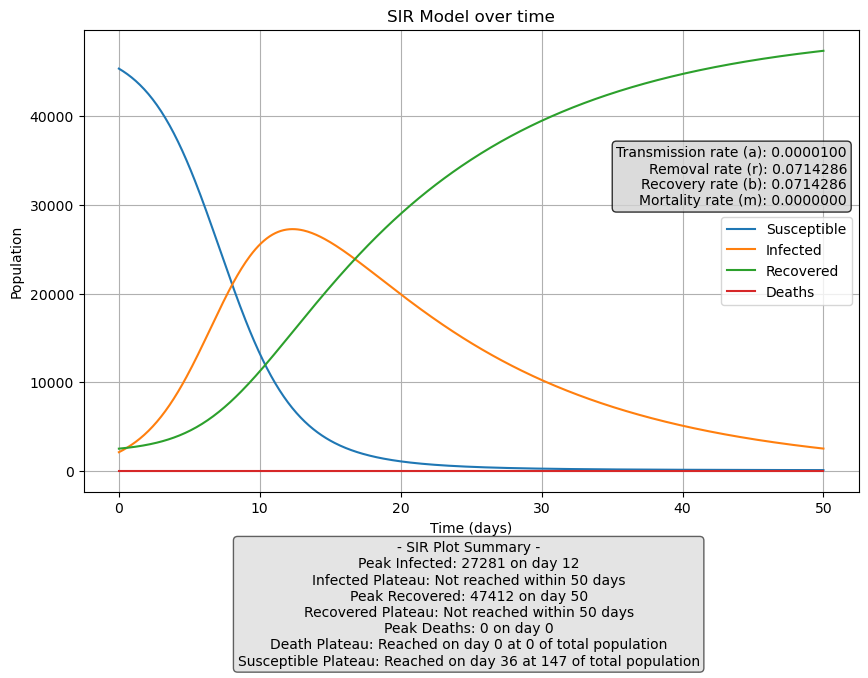

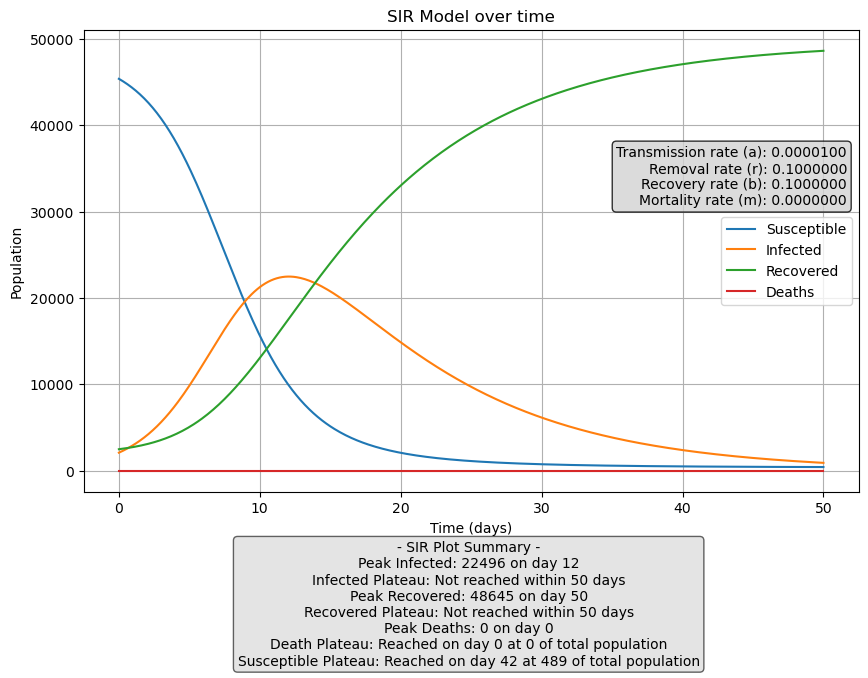

In [3]:
# original givens
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 14,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-1a.txt"}          
SIR(SIR_inputs)

# with recovery coefficient changed to 10
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 10,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-1b.txt"}          
SIR(SIR_inputs)

**Question 2:** Using your SIRPLOT code above, explore what happens when you change the length of time a disease takes to recover (which may happen with a new medicine for example). Provide examples from your model in code blocks and context and explanation in textblocks.



We see that as the length of time a disease takes to recover increases, the number of peak infected rises and the number of Peak recovered lessens.  50 days with the other givens from the book is not long enough to reach a plateau yet for infected and recovered but we do see that as recovered time get's larger the time for the amount of susceptible to reach it's plateau lessens, which would be related to how the infected curve rises quickly taking up the majority of the total population. 

The inverse of this would be that with a medicine that brings down the time it takes to recover we see less infected at the diseases peak and more recovered within the same time period. 

In my last graph example I showed a recovery rate of 50 and this one really shows how as the recovery time increases the sharp jump in infected early, and how the recovery population increases more linearly (in appearance mostly), but the seeing the dramatic contrast helps to illustrate both what happens at recovery rates that happen quickly in days and ones that are really long.

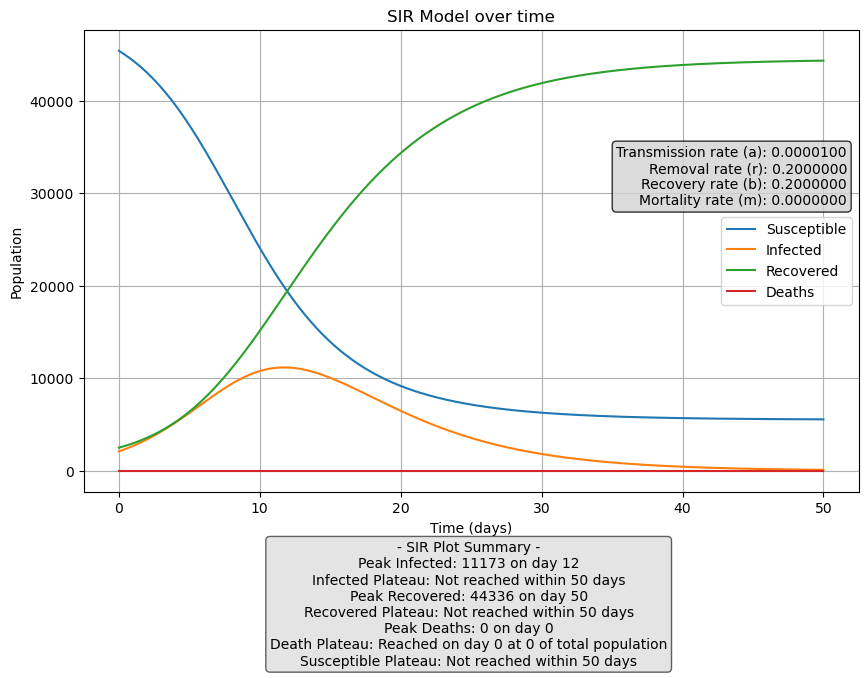

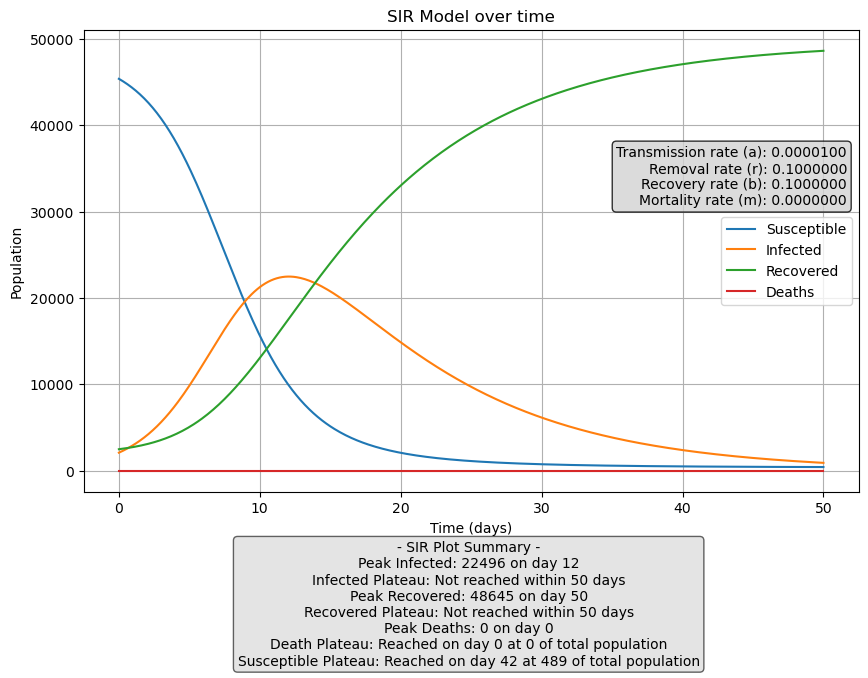

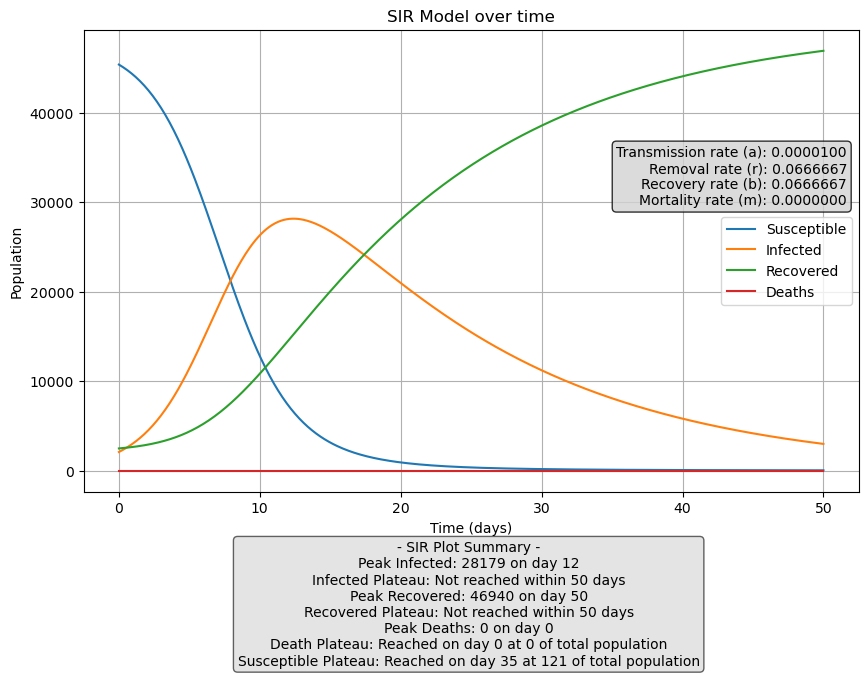

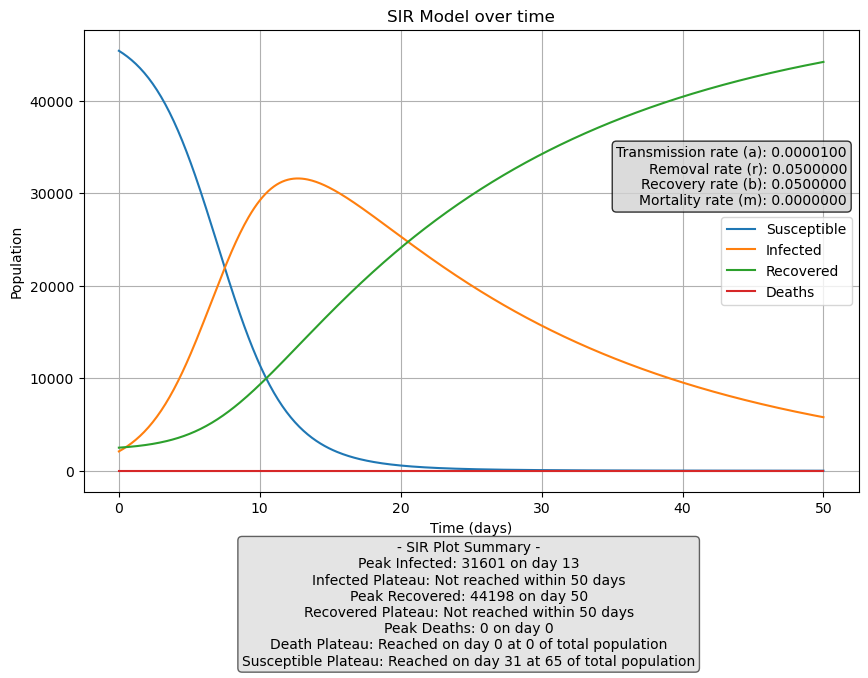

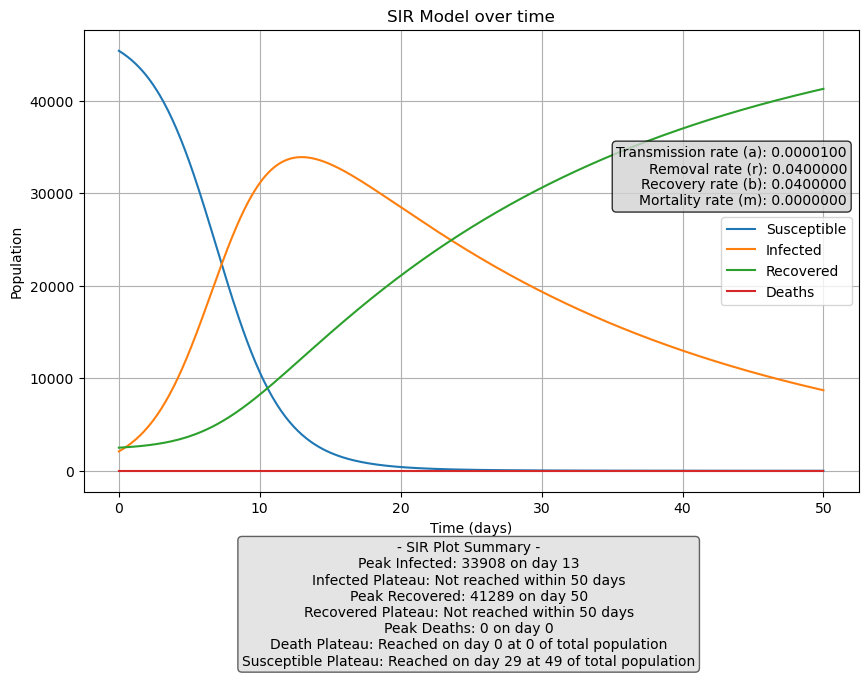

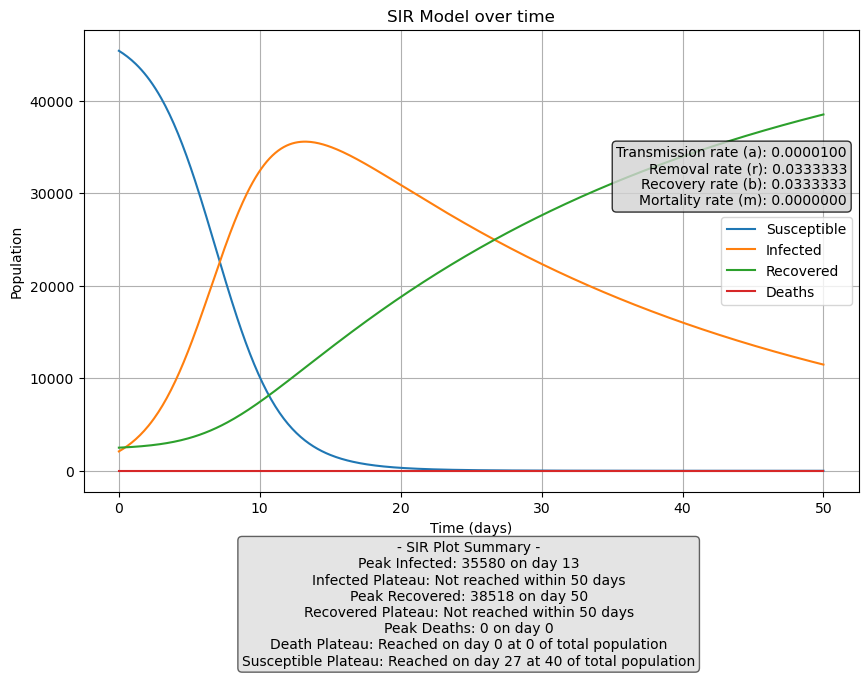

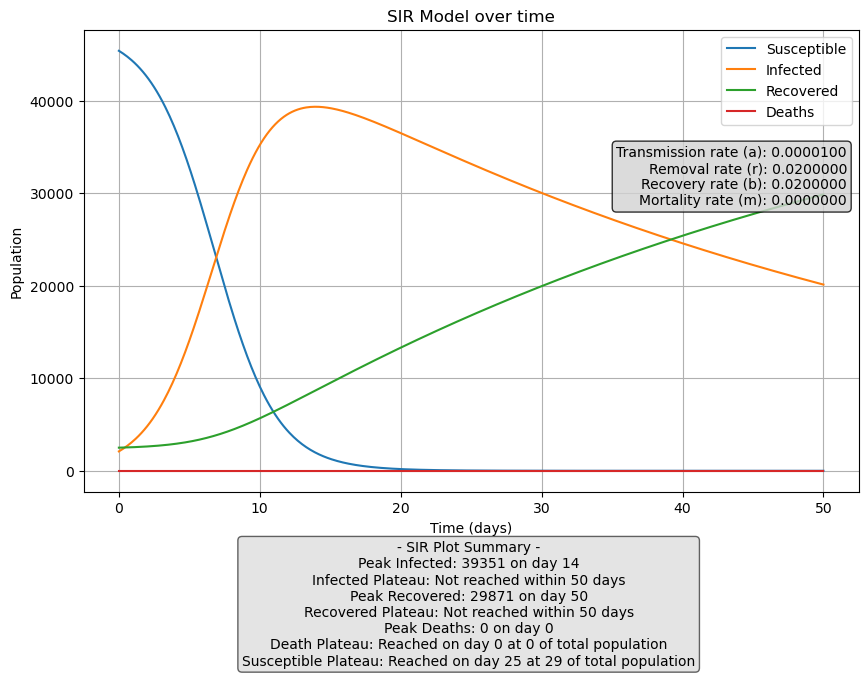

In [4]:
# b changed to 5
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 5,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-2-5.txt"}          
SIR(SIR_inputs)

# b changed to 10
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 10,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-2-10.txt"}          
SIR(SIR_inputs)

# b changed to 15
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 15, 
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-2-15.txt"}          
SIR(SIR_inputs)

# b changed to 20
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 20,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-2-20.txt"}          
SIR(SIR_inputs)

# b changed to 25
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 25,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-2-25.txt"}          
SIR(SIR_inputs)


# b changed to 30
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 30,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_output-2-30.txt"}          
SIR(SIR_inputs)

# b changed to 50
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 50,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-2-50.txt"}          
SIR(SIR_inputs)

**Question 3:** Using your SIRPLOT code above, explore what happens to the course of a disease when you change the transmission coeffient a (which happens if people self-isolate for example). Provide examples from your model in code blocks and context and explanation in textblocks.

We see progressively sharper changes as the transmission coeeficient either get's smaller or larger. Smaller means that it doesn't transmit as well, whether that's from self-isolation, the nature of the disease, or some other reason), a larger transmission coefficient produces a rapid change. In the first 3 plots we see the change in a from it's smallest at 0.000001 to the original given of 0.00001. At it's smallest we barely see changes in any of S, I, or R, as the infection isn't spreading fast enough to have an overall effect, we see as how we approach 0.00001 that change. The 4 graphs after that go from 0.00004 to 0.0001 and see how as the transmission rate increases we see a rapid early spike in infections and a rapid early drop in susceptible as basically the entire population becomes infected in the first several days.

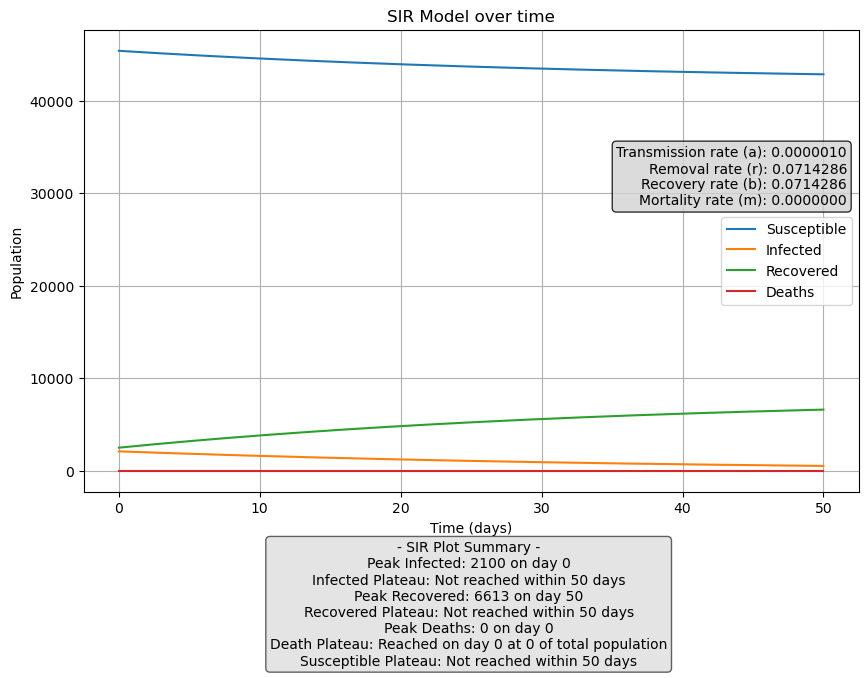

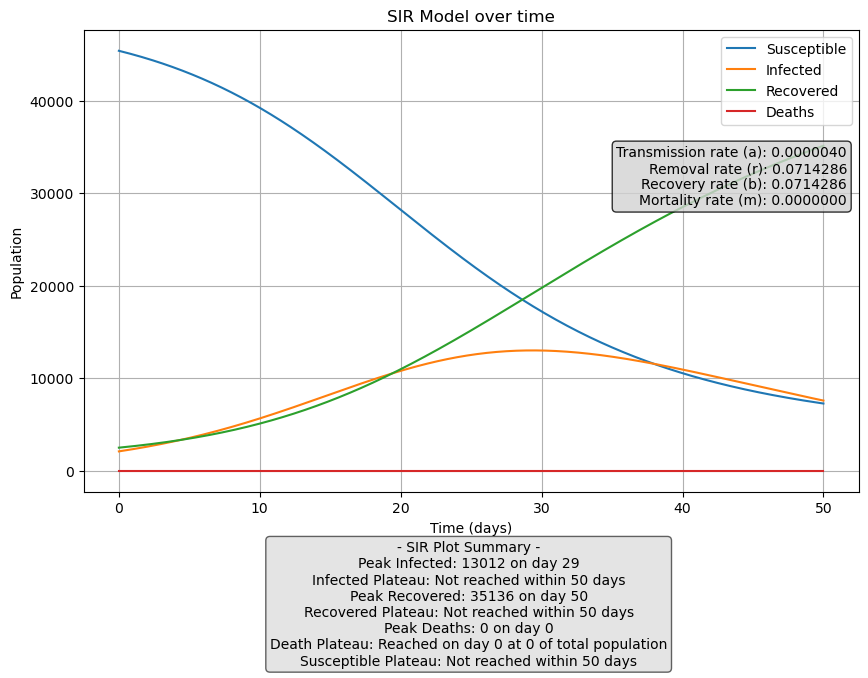

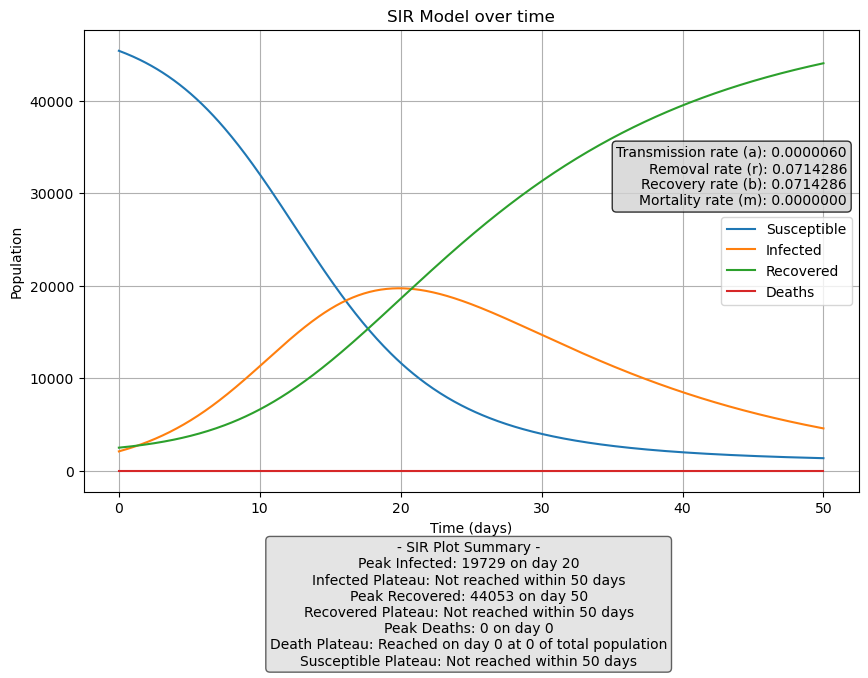

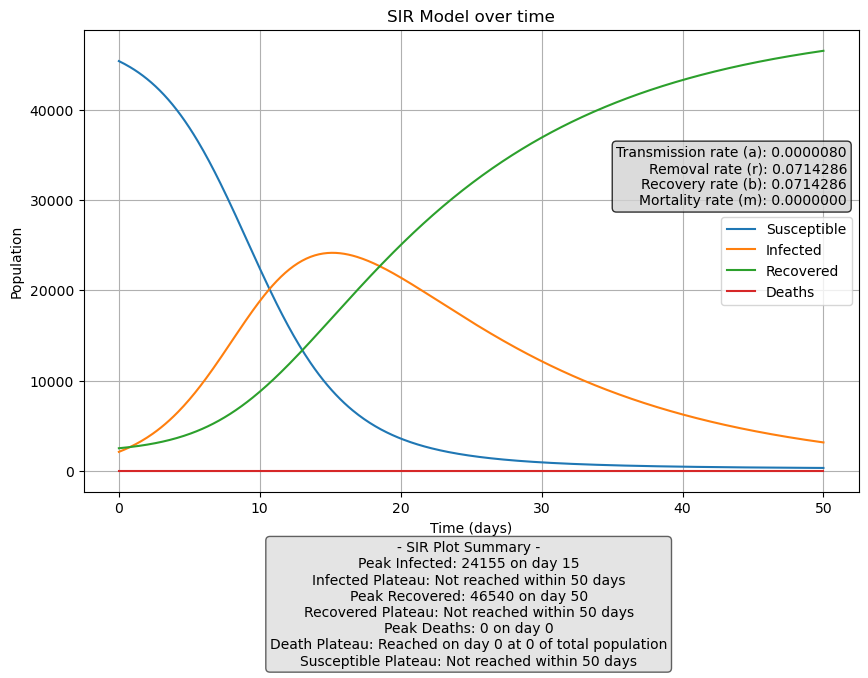

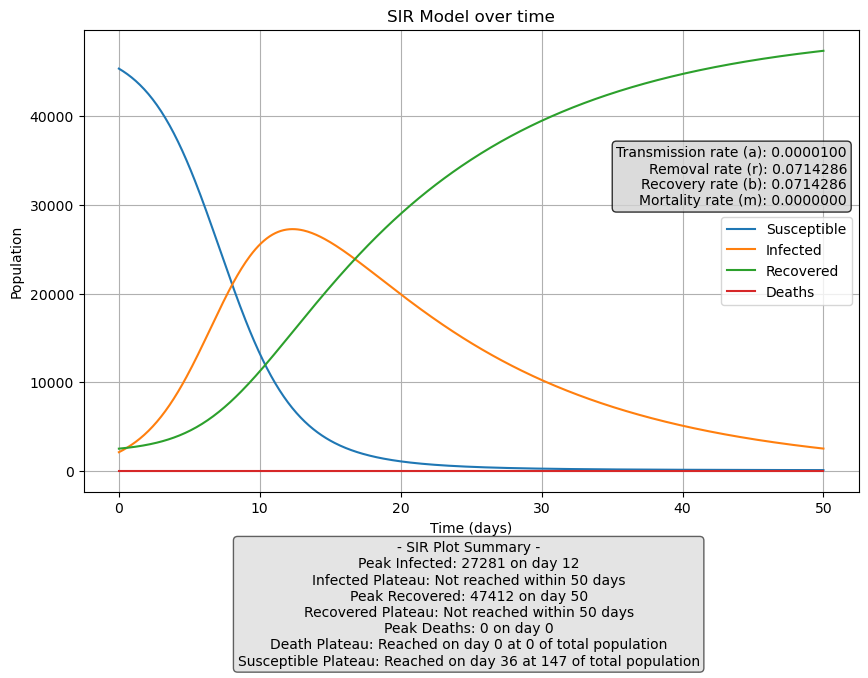

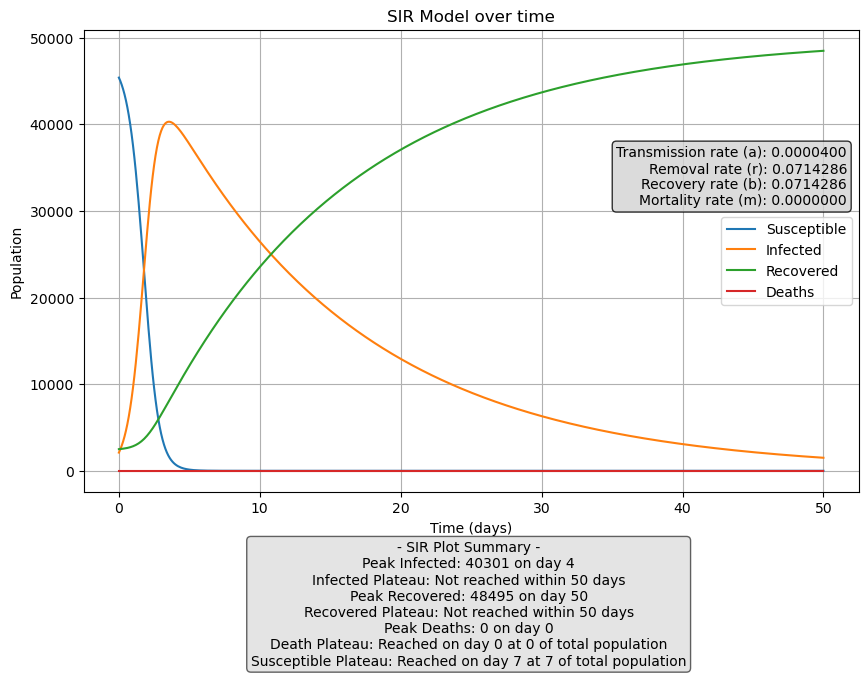

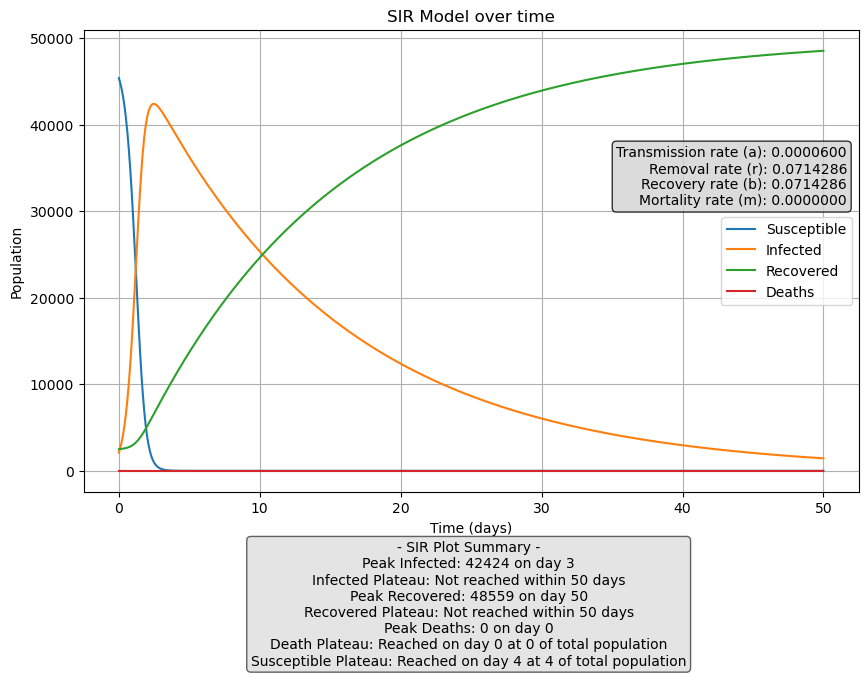

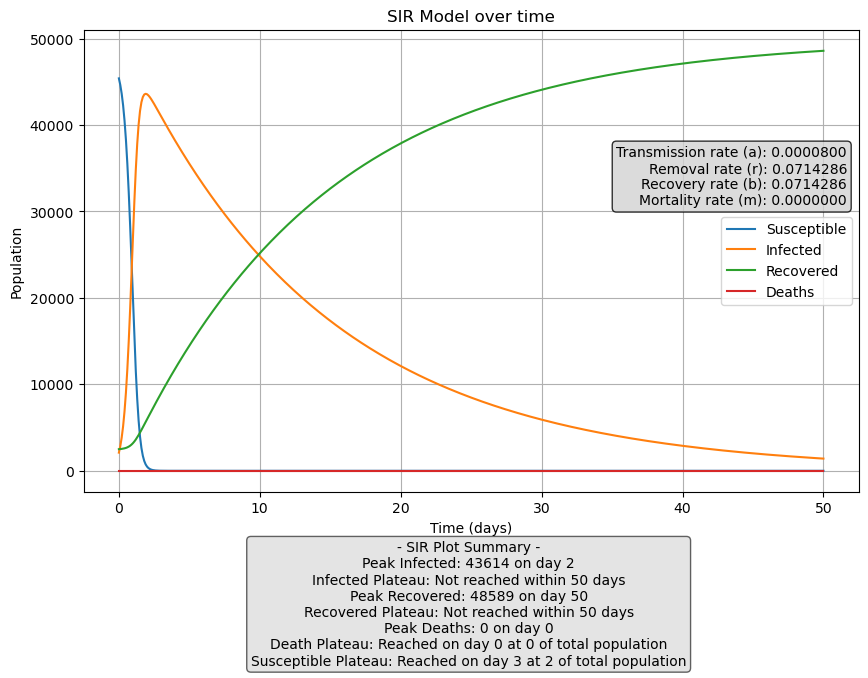

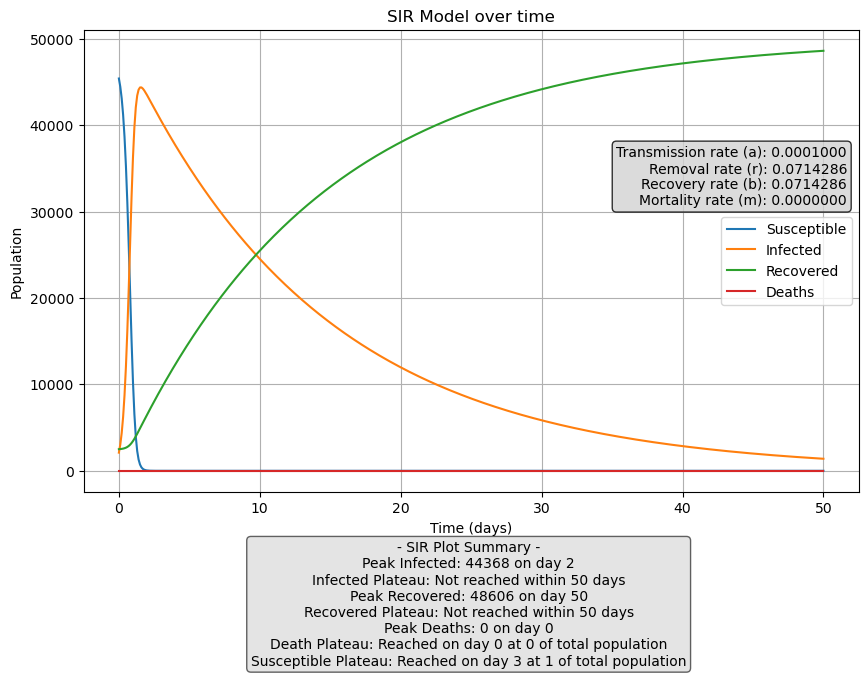

In [5]:
# a changed to 0.000001
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.000001, "B" : 14, 
              "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
              "D_init" : 0, "output_path" : "sir_output-3-001.txt"}          
SIR(SIR_inputs)

# a changed to 0.000004
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.000004, "B" : 14, 
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-004.txt"} 
SIR(SIR_inputs)

# a changed to 0.000006
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.000006, "B" : 14,
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-006.txt"}
SIR(SIR_inputs)

# a changed to 0.000008
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.000008, "B" : 14,
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-008.txt"}
SIR(SIR_inputs)

# the givens, a at 0.00001
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00001, "B" : 14,
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-010.txt"}
SIR(SIR_inputs)

# a changed to 0.00004
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00004, "B" : 14,
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-040.txt"}
SIR(SIR_inputs)

# a changed to 0.00006
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00006,"B" : 14,
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-060.txt"}
SIR(SIR_inputs)

# a changed to 0.00008
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.00008, "B" : 14,
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-080.txt"}
SIR(SIR_inputs)

# a changed to 0.0001
SIR_inputs = {"t_initial" : 0, "t_final" : 50, "step_scale" : 10, "a" : 0.0001, "B" : 14,
                "total_pop" : 50000,  "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500, 
                "D_init" : 0, "output_path" : "sir_output-3-100.txt"}
SIR(SIR_inputs)

**SIR with Differential Equations**

**Question 4:**
Look at the following implementation of SIR (adapted from the https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/) using differential equations. 

How is it the same and how is it different to SIRPLOT? Answer here with code and text examples.

There are many similarities between the two. Both my SIR algorithm and the one below derive S in the same way, and while we do it in slightly different orders the way calculation of b, what I call the Removal rate, the recovery rate, and death rate are all calculated the same and so the derivatives used in this are calculated the same as the derivatives/prime values of I,R,D calculated in my SIR algorithm. 

Susceptible calculation
mine:
- S = total_pop - I - R - D       # total susceptible
deriv:
- S0 = N - I0 - R0
The main difference here is that mine has the flexiblity to look at the total population including deaths within that population if for instance we are looking at a disease a couple weeks in and some of that population have already died. So in way mine is slightly more flexible. The deriv algorithm is set up to only look at from day 0 when no deaths have yet to occur. 

Calculation of b/B, recovery rate, death/mortality rate and the primes for I, R, D
Besides the name changes and a slight order in difference these are calculated exaclty the same

mine:
- B :                   # coefficient for removal of Infected / X days
- r = 1/B                         # removal (recovery + deaths) rate
- b = r * (1 - mortality_risk)    # recovery rate
- m = r * mortality_risk          # mortality rate
- Iprime = (a * S * I) - (I * r)
- Rprime = I * b
- Dprime = I * m

deriv:
- days=10 #(days to recover - how long are the infected able to pass it on )
- a=.0005 #(more contact, how quickly it spreads)
- b=1/days 
- deathrate = .01
- recover = 1 - deathrate
- dIdt = a * S * I  - b * I
- dRdt = recover * (b * I)
- dDrt = deathrate * (b * I) 

To map the similarities we see that:
- r is the same as b, I'm just naming it the removal rate to indicate it includes both recovery and deaths
- Iprime = (a * S * I) - (I * r) is the same dIdt = a * S * I  - b * I
- my b and m are then the same as what's calculated for dRdt and dDrt as recover * b and deathrate * b. We do things in a slightly different order but the end calculations are the same.
    - b = r * (1 - mortality_risk)    # recovery rate
    - m = r * mortality_risk          # mortality rate
    - Rprime = I * b
    - Dprime = I * m
    - versus
    - deathrate = .01
    - recover = 1 - deathrate
    - dRdt = recover * (b * I)
    - dDrt = deathrate * (b * I) 
    

The first difference I see is that my function is able to do multiple steps per day while the deriv function is only set up for 1 step for 1 day, and so in that way could seemingly be considered less precise than my function, however we'll see next that isn't the case, that the deriv function is actually more precise.

The main difference though between the two is how the algorithm actually works. Mine is based of Eulers method, the basic idea being that next_value = current_value + delta * timestep. While simple and intuitive, it can accumulate error and is sensitive to timestep size, what I mentioned above about the step_size is one way to reduce that error and sensitivity. 

The deriv function is using the the odeint method and is considered an adaptive step-size ODE (ordinary differential equation) solver, similar to how a lsoda algorithm would work, it automatically adjusts step size for optimal accuracy and handles stiffness better. As a result, the deriv function is more accurate overall, even though it conceptually solves the same.  

The next difference I find really cool, is how the deriv function stores and organizs the results, my algorithm appends each S, I, R, D value to a separate list at each timestamp. The Deriv algorithm uses odeint to return a 2D array (matrix) where each row corresponds to a time step and each column corresponds to S, I, R, D. It then uses .T (ret.T) to transpose, and so reorganizes the matrix so that S, I, R, and D become separate vectors for easy plotting. I find this approach more elegant and efficient then the method for the original SIR.

**Question 5:**
Can you use this model to explore the Questions 2 and 3 above. Answer here.

/tmp/ipykernel_418/3022371191.py:65: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


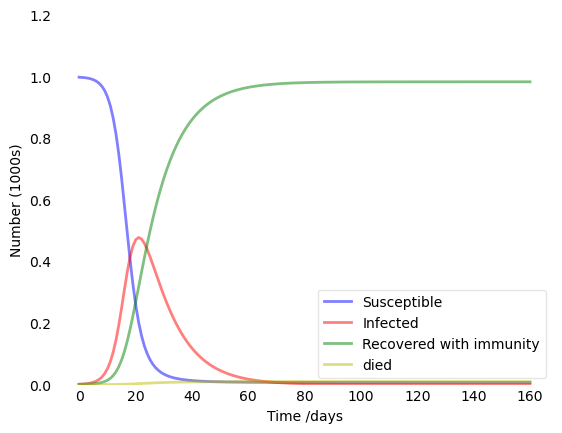

In [6]:


#Using Differential Equations


# Total population, N.
N = 1000

timeperiod =160
# Initial number of infected and recovered individuals, I0 and R0.
I0=1
R0 =1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

D0 =0


#TRY modifying a and b

# Contact rate, a, and mean recovery rate, b, (in 1/days).

days=10 #(days to recover - how long are the infected able to pass it on )

a=.0005 #(more contact, how quickly it spreads)

b=1/days 

deathrate = .01
recover = 1 - deathrate





# A grid of time points (in days)
t = np.linspace(0, 160, timeperiod)

# The SIR model differential equations.
def deriv(y, t, N, a, b):
    S, I, R, D = y
    dSdt = -a * S * I 
    dIdt = a * S * I  - b * I
    dRdt = recover * (b * I)
    dDrt = deathrate * (b * I) 
    return dSdt, dIdt, dRdt, dDrt

# Initial conditions vector
y0 = S0, I0, R0, D0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, a, b))
S, I, R, D = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
#ax = fig.add_subplot(111, axis_bgcolor='#dddddd', axisbelow=True)
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, D/1000, 'y', alpha=0.5, lw=2, label='died')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

With a few tweaks to the variables, yes, this algorithm could be used to explore the questions 2 and 3 above. Below you'll see my changes, which also include some restructuring to be able to use as function and to feed through my plotting algorithm instead of this one used above, to more easily show differences. The appearance doesn't change much, but looking at the summary of peaks and plateau's below the graph we see very slight differences, mostly around identifying the beginning of the plateau's.

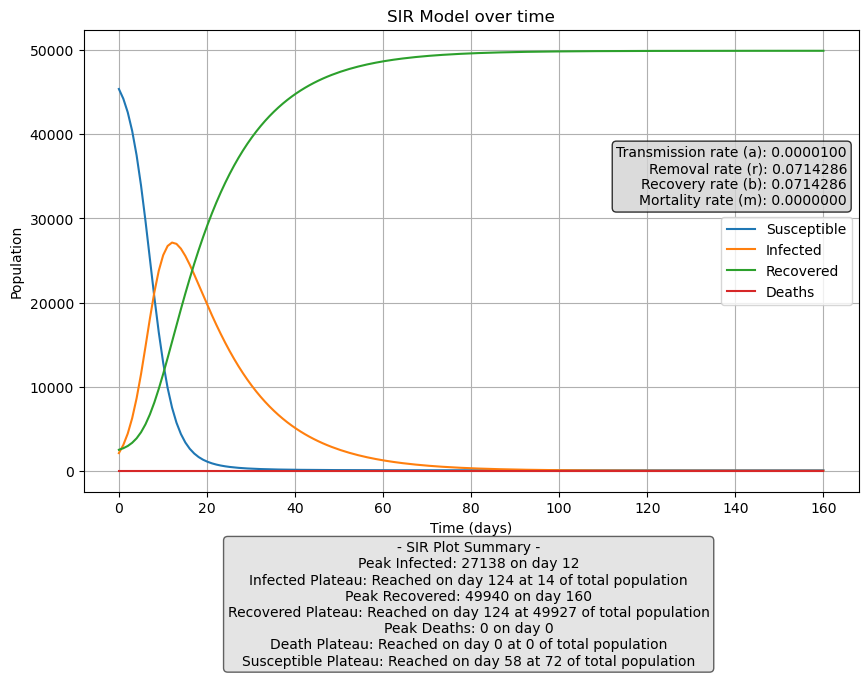

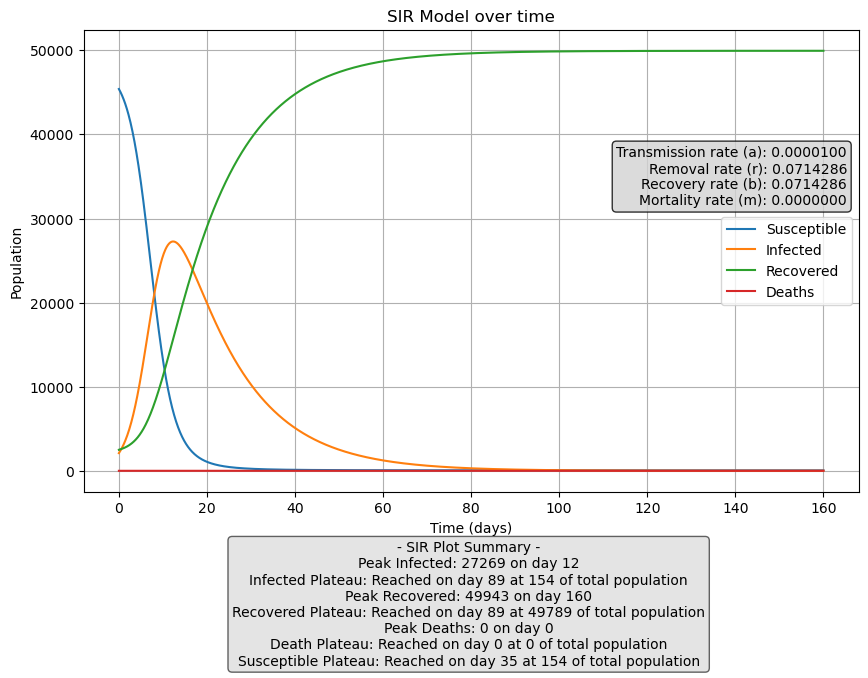

In [17]:
# The SIR model differential equations.
def deriv(y, t, N, a, b, recover, deathrate):
    S, I, R, D = y
    dSdt = -a * S * I 
    dIdt = a * S * I  - b * I
    dRdt = recover * (b * I)
    dDrt = deathrate * (b * I) 
    return dSdt, dIdt, dRdt, dDrt

            
# dictionary of SIR_inputs outline
    # timeperiod :          # end day of model
    # a :                   # transmission coefficient, rate of people getting sick per contact
    # days :                #(days to recover - how long are the infected able to pass it on )
    # N :                   # total Population
    # deathrate :           # percentage (in decimal form) of those that are infected that die
    # I_init :              # infected on start day
    # R_init :              # recovered on start day
    # D_init :              # deaths on start day       
def SIR_deriv(SIR_inputs):
    # deserialize SIR_inputs into variables
    I_init = SIR_inputs["I_init"]
    R_init = SIR_inputs["R_init"]
    D_init = SIR_inputs["D_init"]

    # Initial number of infected and recovered individuals, I0 and R0.
    I0= I_init
    R0 = R_init
    # Everyone else, S0, is susceptible to infection initially.
    N = SIR_inputs["N"]    
    S0 = N - I0 - R0
    D0 = D_init

    # Contact rate, a, and mean recovery rate, b, (in 1/days).
    a = SIR_inputs["a"]
    #(days to recover - how long are the infected able to pass it on )
    days = SIR_inputs["days"] 
    b=1/days 
    deathrate = SIR_inputs["deathrate"]
    recover = 1 - deathrate

    timeperiod = SIR_inputs["timeperiod"]
    # A grid of time points (in days)
    t = np.linspace(0, 160, timeperiod)
    
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, a, b, recover, deathrate))
    S, I, R, D = ret.T
    
    # plot SIR Graph
    plotSIR(a, days, (recover * b), (deathrate * b), list(t), list(S), list(I), list(R), list(D), N, 0, timeperiod)
    

# deriv algorithm
SIR_inputs = {"timeperiod" : 160, "a" : 0.00001, "days" : 14,
                "N" : 50000, "deathrate" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0}          
SIR_deriv(SIR_inputs)

# euler algorithm
SIR_inputs = {"t_initial" : 0, "t_final" : 160, "step_scale" : 11, "a" : 0.00001, "B" : 14,
                "total_pop" : 50000, "mortality_risk" : 0, "I_init" : 2100, "R_init" : 2500,
                "D_init" : 0, "output_path" : "sir_euler_output-5.txt"}          
SIR(SIR_inputs)


**SIR with Matrices**

**Question 6:**
How is this implementation the same and different than SIRPLOT and the differential equation SIRmodel? Can you explore changes in the transmission coefficent and recovery rate the same way? Answer here.

Both the matrix model and the SIRPLOT/differential equation models track how a disease spreads through susceptible, infected, recovered, and deceased groups over time, and both use parameters like the infection rate and recovery rate to do it. The difference is in how they move people between groups. In the matrix model, every day you multiply the current state by a fixed matrix (A), so the same percentage of people move between groups each day no matter what. In the differential equation SIR model, the rates depend on how many people are currently susceptible and infected, so as the number of susceptibles drops, the infection rate naturally slows down. It gives you a spread that feels more dynamic, where the disease kind of burns out as fewer people are left to catch it.

Because of that, even though you can still explore changes in the transmission coefficient (a) and the recovery rate (rI) in the matrix model, it’s a lot less flexible. You’d have to rebuild the matrix manually every time you wanted to tweak something, and even then, it wouldn’t naturally adjust the infection rate as people recover. In the differential equation model, changing 'a' or 'rI' right away changes how the disease spreads over time without needing to rebuild anything, and the infection curve adjusts itself based on how many people are still susceptible. It ends up being more realistic and easier to work with when you want to see how the disease behaves over time.

**Question 7:**
What are the advantages and disadvantages of this matrix model?  Answer here.

The matrix model has a few big advantages. It’s super simple to set up, runs really fast even if you’re simulating a lot of days, and gives you a really clear picture of how people are moving between health states over time. For small-scale problems or cases where the infection dynamics don’t change much, it can actually work pretty well without needing a lot of coding. And since the matrix doesn’t change, it’s completely deterministic, so if you run it with the same starting conditions, you’ll always get the same results.

But the matrix model also comes with some major downsides. The biggest one is that it doesn’t adjust the infection rate based on how many people are still susceptible or already infected, which means it can’t really show important real-world things like herd immunity or how outbreaks slow down on their own. If you want to model something like lockdowns or vaccines coming into play, you’d have to stop and manually change the matrix, which gets clunky fast. So even though the matrix model is nice for basic simulations, if you want something that feels more real and responds as the situation changes, the differential equation SIR model is a much better fit.

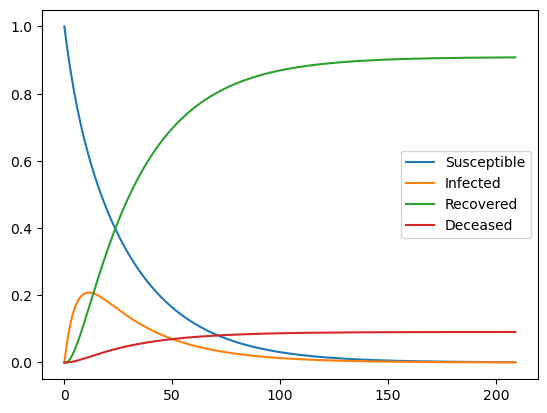

In [8]:
T  = 210 #number of days
a= .05         # % new infection each day
aS= 1 - a      # % remain suseptible
rnI= .04       # recover no immunity
rI= .1         # recover with immunity
rD= .01        # die from disease


A = np.matrix([[aS,rnI,0,0],[rnI+rD,(1-(rnI +rI + rD)) ,0,0],[0,rI,1,0],[0,rD,0,1]]) #dynamics matrix
x1 = np.array([1,0,0,0]) #initial state: everyone healthy
stateTraj = np.hstack([np.vstack(x1),np.zeros((4,T-1))]) #initialize trajectory with 0s
for t in range(T-1):
    stateTraj[:,t+1] = np.matmul(A,stateTraj[:,t])

for i in range(len(stateTraj)):
    plt.plot(range(T),stateTraj[i])

plt.legend(["Susceptible","Infected","Recovered","Deceased"])

**Question 8:**
Read Calculus in Context, Chapter 4. This explores additional models that can be explored using this method. 
Copy and paste SIR plot here and  modify to model the Lotka-Voerra Model from page 193 number 7. Explore some of the questions a - f on your own and add some short notes about this model. note: The scaling factor for lynx is 60 (page 194, part c)."plot H and 60L"




**Question 9:**
Chapter 4 explores additional models that can be explored using this method. 
Copy and paste SIR plot here and  modify to model the Fermentation Model from page 195 numbers 8/9/10/11.  HOWEVER, to implement the model you must work through all the steps. YOu may discuss in Piazza.





**Question 10:** 

Create your own species (or other) SIR type model. 

For example, can you add elements to SIR that model some percentage of infected dying? Or immunity that is not permentant?  Or create an ecosystem of your own (Aliens eat bears,bears eat mice, Mice drink wine?). You may discuss ideas on Piazza and I can help with your equations :)


Provide code, sample output, and description.

**Finally:**
    
What are some thoughts about modeling from this project? 
Which model was the simpliest?
Which expressed the underlying ideas best?
Which was good for a "snapshot" of the ideas?
As we use more packages for mathematical modelling do we sometimes loss track of the ideas?

**Want more?** Check out Chapter 8 in Calculus in Context. This project is the gateway to Dynamical Systems.